![Image](https://drive.google.com/uc?export=view&id=10B8NecPfn9sXRescmijQ8Zc2CO08fQm7)

## **Effective Date Column Handling in Pandas**
### ACC Tech Challenge Series, Winter 2020
### Terry Wang

Source:

https://towardsdatascience.com/simple-football-data-set-exploration-with-pandas-60a2bc56bd5a

https://medium.com/datadriveninvestor/how-to-work-with-dates-in-pandas-like-a-pro-a84055a4819d

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

Download Data Here:

https://drive.google.com/open?id=1laN3QjJzkzqqwXOsQ30Sz_XILBmQ6hJ2

In [70]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
results = pd.read_csv('results.csv')
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


### **Converting date column to `datetime` data type**

In [71]:
results.dtypes

date          object
home_team     object
away_team     object
home_score     int64
away_score     int64
tournament    object
city          object
country       object
neutral         bool
dtype: object

Convert `date` column to datetime dtype, using pandas function `to_datetime`.

In [72]:
results['date_time'] = pd.to_datetime(results.date)

In [73]:
results.dtypes

date                  object
home_team             object
away_team             object
home_score             int64
away_score             int64
tournament            object
city                  object
country               object
neutral                 bool
date_time     datetime64[ns]
dtype: object

When a column is `datetime` type, you can easily extract dates, resample, apply window functions, etc. directly using pandas.

Let's say I want to only use the year of the date in each observation, I can do the following:

In [74]:
# Access 

results.date_time.dt.year.head()

0    1872
1    1873
2    1874
3    1875
4    1876
Name: date_time, dtype: int64

In [75]:
# Count the number of observations for each year:

results.date_time.dt.year.value_counts().sort_index().head()

1872    1
1873    1
1874    1
1875    1
1876    2
Name: date_time, dtype: int64

And since pandas dataframes are integrated with matplotlib, you can directly plot the trendline:

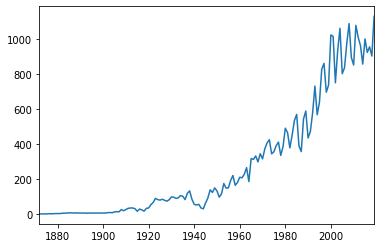

In [76]:
results.date_time.dt.year.value_counts().sort_index().plot()

Since the output of the `.year` method is an array of the same length as the number of rows in the dataset, you can also use this as an indexing tool to filter rows.

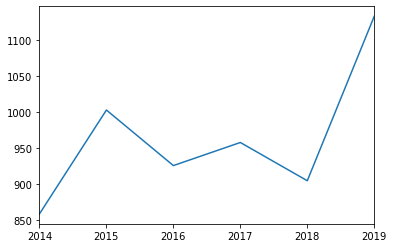

In [77]:
results.date_time.dt.year[results.date_time.dt.year >= 2014].value_counts().sort_index().plot()

Use `.between` for easier indexing.

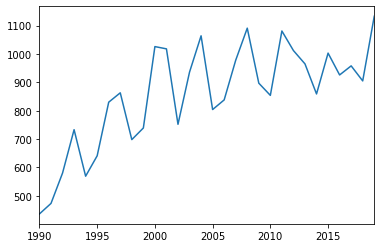

In [78]:
results.date_time.dt.year[results.date_time.dt.year.between(left=1990, right=2019)].value_counts().sort_index().plot()

Can use resample methods after making a datetime column the index, which opens up possibilities to apply window functions.

In [81]:
results_ymd = results.drop("date", axis=1).set_index("date_time")
results_ymd.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date_time,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


You can also use other date formats as well, for example:

In [83]:
# Reformatting the date column

results_ym = results.drop(["date", "date_time"], axis=1).set_index("date_time_ym")
results_ym.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date_time_ym,,,,,,,,
1872-11,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03,England,Scotland,4,2,Friendly,London,England,False
1874-03,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03,England,Scotland,2,2,Friendly,London,England,False
1876-03,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


However, note that this operation will make the reformatted date_time column into a string and not `datetime` dtype, so if you set this as the index column a lot of the methods below will not be available to you, so be sure to pass any date column you want to use as index through the `pd.to_datetime()` first.

In [95]:
# Index column now is object and not datetime

results_ym.index.dtype

dtype('O')

### **`resample` method**

Resample is similar to group by in the sense that it will allow you to bin the rows using some rule, so that you can apply your operation on each bin. Below is an example of summing the numerical columns for each month.  Note that if there will be **ONE ROW FOR EACH MONTH BETWEEN THE MIN AND MAX MONTH IN THE DATASET, even if there are no observations corresponding to certain months**.  This can be useful or a nuisance depending on your use case, but for most time series problems, this can be a good way to fill missing data, as the structure of the data requires that each observation is from time intervals of equal lengths.

In [84]:
# Use results.resample("M", on="date_time") if date_time is a column and not the index

results_ymd.resample("M").sum().head(10)

,home_score,away_score,neutral
date_time,,,
1872-11-30,0,0,0.0
1872-12-31,0,0,0.0
1873-01-31,0,0,0.0
1873-02-28,0,0,0.0
1873-03-31,4,2,0.0
1873-04-30,0,0,0.0
1873-05-31,0,0,0.0
1873-06-30,0,0,0.0
1873-07-31,0,0,0.0


### **`rolling` method**

`rolling` method allows you to apply window functions to a time series data.  You can use time intervals directly as an argument to the method:

In [85]:
# To get total number of goals for each 90 day period in the dataset:

results_ymd.resample("M").sum().resample("90d").sum().head()

,home_score,away_score,neutral
date_time,,,
1872-11-30,0,0,0.0
1873-02-28,4,2,0.0
1873-05-29,0,0,0.0
1873-08-27,0,0,0.0
1873-11-25,0,0,0.0


Note that since our datetime index is in terms of days (that's the smallest unit here), we would have to make the rolling window in terms of days as well, or pandas will return an exception.  If you want the window to be measured in terms of months, simply convert that length in terms of days.  

The function you choose to apply to the window is arbitrary as well using `.apply()` at the end, as long as it is able to take an array of numbers and reduce it to one number (for example, the `.mean()` function is basically taking an array of numbers in a column within the window and outputting the mean of it).

### **Frequency**

When the data points of a time series are uniformly spaced in time (e.g., hourly, daily, monthly, etc.), the time series can be associated with a frequency in pandas. This is an alternative way to make the time interval between rows uniform and even quickly interpolate any missing data.

In [103]:
results_first5 = results_ymd.head()
results_first5

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date_time,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-08,England,Scotland,4,2,Friendly,London,England,False
1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
1875-03-06,England,Scotland,2,2,Friendly,London,England,False
1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [105]:
# assign monthly frequency to the date_time column to make each row a month from 1872-11-30 to 1876-03-04
# each row now represents a month with any missing data filled with data from the last valid observation before the index date
results_first5.asfreq("M", method='pad')

,home_team,away_team,home_score,away_score,tournament,city,country,neutral
date_time,,,,,,,,
1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1872-12-31,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-01-31,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-02-28,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1873-03-31,England,Scotland,4,2,Friendly,London,England,False
1873-04-30,England,Scotland,4,2,Friendly,London,England,False
1873-05-31,England,Scotland,4,2,Friendly,London,England,False
1873-06-30,England,Scotland,4,2,Friendly,London,England,False
1873-07-31,England,Scotland,4,2,Friendly,London,England,False
